In [1]:
import psycopg2
import os
from dotenv import load_dotenv
import pandas as pd
from matplotlib.pyplot import subplots

load_dotenv()

database_password = os.environ.get("DATABASE_PASSWORD")
database_username = os.environ.get("DATABASE_USERNAME")
database_host = os.environ.get("DATABASE_HOST")
database_port = os.environ.get("DATABASE_PORT")
database_name = os.environ.get("DATABASE_NAME")

connection = psycopg2.connect(database=database_name,
                        host=database_host,
                        user=database_username,
                        password=database_password,
                        port=database_port)
connection.set_session(readonly=True)

In [2]:
def sql_to_dataframe(conn, query):
    """
    Import data from a PostgreSQL database using a SELECT query
    """
    cursor = conn.cursor()
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print(f"Error: {error}”")
        cursor.close()
        return 1
    # The execute returns a list of tuples:
    tuples_list = cursor.fetchall()
    colnames = [desc[0] for desc in cursor.description]
    cursor.close()
    # Now we need to transform the list into a pandas DataFrame:
    df = pd.DataFrame(tuples_list, columns=colnames)
    return df

In [3]:
df =sql_to_dataframe(conn=connection, query="SELECT jcode, COUNT(DISTINCT scrapeid), MIN(checked_time) AS earliest_checked_time, MIN(updated_time) AS earliest_updated_time FROM sitemap_entries GROUP BY jcode")

In [5]:
df

,jcode,count,earliest_checked_time,earliest_updated_time
0,1655211,1,2024-02-07 01:37:35.754137+00:00,2024-02-06 10:13:05+00:00
1,1781994,1,2023-12-10 23:08:38.279511+00:00,2023-10-05 15:55:04+01:00
2,1827428,1,2023-12-10 23:08:38.279511+00:00,2023-11-15 11:52:04+00:00
3,1836718,1,2024-01-07 17:44:55.204141+00:00,2023-12-21 10:18:05+00:00
4,1837379,1,2023-12-10 23:08:38.279511+00:00,2023-02-03 12:45:09+00:00
...,...,...,...,...
9721,1904076,1,2024-03-23 01:36:23.507621+00:00,2024-03-22 18:02:08+00:00
9722,1904077,1,2024-03-23 01:36:23.507621+00:00,2024-03-22 18:03:06+00:00
9723,1904078,1,2024-03-23 01:36:23.507621+00:00,2024-03-22 18:31:05+00:00
9724,1904079,1,2024-03-23 01:36:23.507621+00:00,2024-03-22 18:51:05+00:00


In [8]:
df["earliest_updated_time"] = pd.to_datetime(df["earliest_updated_time"], utc=True)

df_counts_by_date = df.groupby(df["earliest_updated_time"].dt.date).size().reset_index(name="count")

In [9]:
df_counts_by_date["earliest_updated_time"] = pd.to_datetime(df_counts_by_date["earliest_updated_time"])
df_counts_by_date = df_counts_by_date[df_counts_by_date["earliest_updated_time"] >= pd.to_datetime("2024-01-11")]
df_counts_by_date.set_index("earliest_updated_time", inplace=True)

In [10]:
df_counts_by_date = df_counts_by_date.asfreq("D", fill_value=0)

In [11]:
df_counts_by_date

,count
earliest_updated_time,
2024-01-11,118
2024-01-12,185
2024-01-13,0
2024-01-14,1
2024-01-15,159
...,...
2024-03-18,120
2024-03-19,138
2024-03-20,94


Text(0.5, 0.01, '(Quick, non peer-reviewed visualisation based on unofficial once-daily web scraping. \n Civil Service Jobs data is available under the Open Government Licence v3.0)')

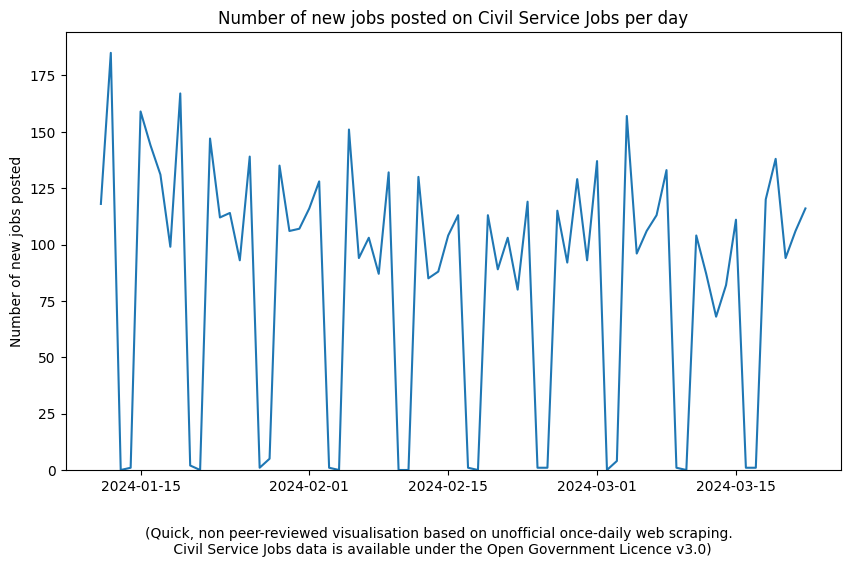

In [12]:
fig, ax = subplots(figsize=(10,6))

ax.plot(df_counts_by_date.index, df_counts_by_date["count"])

ax.set_ylim(bottom=0)

ax.set_title("Number of new jobs posted on Civil Service Jobs per day")

ax.set_ylabel("Number of new jobs posted")

fig.subplots_adjust(bottom=0.15)

fig.text(0.5, 0.01, "(Quick, non peer-reviewed visualisation based on unofficial once-daily web scraping. \n Civil Service Jobs data is available under the Open Government Licence v3.0)", ha="center")